## Hypothesis Testing

In [1]:
# Import Libraries:

import pandas as pd
import numpy as py
import tmdbsimple as tmdb

In [2]:
import json
with open('/Users/jnate/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
#Display the keys of the loaded dict:
login.keys()

dict_keys(['api-key'])

In [3]:
# Load API key:

tmdb.API_KEY =  login['api-key']

In [4]:
# Load JSON files:

with open('Data\\tmdb_api_results_2019.json') as y1:
    jsonfile1 = json.load(y1)

with open('Data\\tmdb_api_results_2020.json') as y2:
    jsonfile2 = json.load(y2)

In [34]:
# Convert separate years to pandas DataFrames:

year2019 = pd.DataFrame(jsonfile1)

# Reduce the DataFrame down to 4 columns:
year2019 = year2019[['imdb_id', 'revenue', 'budget', 'certification', 'runtime']]

# Imputation:

year2019['certification'].replace({'' : 'NR', '' : 'NR'}, inplace = True);

year2019['certification'].fillna('NR', inplace =True)

year2019['revenue'].fillna(0.0, inplace =True)

year2019['budget'].fillna(round(year2019['budget'].mean(),2), inplace = True)

year2019['runtime'].fillna(round(year2019['runtime'].mode(),2), inplace =True)

# Check:

year2019.head()

,imdb_id,revenue,budget,certification,runtime
0,0,0.0,1.914495e+06,NR,90.0
1,tt0385887,18377736.0,2.600000e+07,R,145.0
2,tt0437086,404852543.0,1.700000e+08,PG-13,122.0
3,tt0441881,2078370.0,2.393482e+07,R,119.0
4,tt0448115,365971656.0,8.000000e+07,PG-13,132.0


In [6]:
# Remove ineffectual columns:

year2019.drop(columns= 'imdb_id', inplace =True)

In [35]:
# Convert separate years to pandas DataFrames:

year2020 = pd.DataFrame(jsonfile2)

# Reduce the DataFrame down to 4 columns:
year2020 = year2020[['imdb_id', 'revenue', 'budget', 'certification', 'runtime']]

# Imputation:

year2020['certification'].replace({'' : 'NR', '' : 'NR'}, inplace = True);

year2020['certification'].fillna('NR', inplace =True)

year2020['revenue'].fillna(0.0, inplace =True)

year2020['budget'].fillna(round(year2020['budget'].mean(),2), inplace = True)

year2020['runtime'].fillna(round(year2020['runtime'].mode(),2), inplace =True)

# Check:

year2020.head()

,imdb_id,revenue,budget,certification,runtime
0,0,0.0,1026934.58,NR,0.0
1,tt0062336,0.0,0.00,NR,63.0
2,tt0093119,0.0,7500000.00,NR,74.0
3,tt0805647,26900000.0,0.00,PG,106.0
4,tt0920462,106045.0,0.00,R,97.0


In [36]:
# Remove ineffectual columns:

year2020.drop(columns= 'imdb_id', inplace = True)

In [37]:
# Check for duplciates:

year2019.duplicated().sum()

0

In [38]:
# Check for duplciates:

year2020.duplicated().sum()

2859

In [43]:
# Removal of duplciates

year2019.drop_duplicates()

year2020.drop_duplicates()

,revenue,budget,certification,runtime
0,0.0,1026934.58,NR,0.0
1,0.0,0.00,NR,63.0
2,0.0,7500000.00,NR,74.0
3,26900000.0,0.00,PG,106.0
4,106045.0,0.00,R,97.0
...,...,...,...,...
3701,11136444.0,7907534.00,NR,135.0
3702,0.0,2000000.00,NR,98.0
3703,6435260.0,20000000.00,NR,113.0
3707,0.0,0.00,R,119.0


In [44]:
year2019.duplicated().sum()

0

In [48]:
year2020.duplicated().sum()

2859

In [49]:
year2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4677 entries, 0 to 4676
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   imdb_id        4677 non-null   object 
 1   revenue        4677 non-null   float64
 2   budget         4677 non-null   float64
 3   certification  4677 non-null   object 
 4   runtime        4648 non-null   float64
dtypes: float64(3), object(2)
memory usage: 182.8+ KB


In [50]:
year2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3718 entries, 0 to 3717
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        3718 non-null   float64
 1   budget         3718 non-null   float64
 2   certification  3718 non-null   object 
 3   runtime        3717 non-null   float64
dtypes: float64(3), object(1)
memory usage: 116.3+ KB


In [51]:
# Removal of NaN values:

year2019.dropna(inplace = False)
year2020.dropna(inplace = False)

,revenue,budget,certification,runtime
0,0.0,1026934.58,NR,0.0
1,0.0,0.00,NR,63.0
2,0.0,7500000.00,NR,74.0
3,26900000.0,0.00,PG,106.0
4,106045.0,0.00,R,97.0
...,...,...,...,...
3713,0.0,0.00,NR,92.0
3714,0.0,0.00,NR,92.0
3715,0.0,0.00,NR,103.0
3716,0.0,0.00,NR,0.0


In [52]:
year2019.isna().sum()

imdb_id           0
revenue           0
budget            0
certification     0
runtime          29
dtype: int64

In [53]:
# Remove 2019 movies with 0 budget and 0 revneue:

budget19 = year2019['budget'] !=0
revenue19 = year2019['revenue'] !=0
runtime = year2019['runtime'] !=0

df19 = year2019[(year2019['budget'] !=0) & (year2019['revenue'] !=0) & (year2019['runtime'] !=0)]

df19.head()

,imdb_id,revenue,budget,certification,runtime
1,tt0385887,18377736.0,26000000.0,R,145.0
2,tt0437086,404852543.0,170000000.0,PG-13,122.0
3,tt0441881,2078370.0,23934823.0,R,119.0
4,tt0448115,365971656.0,80000000.0,PG-13,132.0
5,tt0783640,3364426.0,20000000.0,R,110.0


In [54]:
# Remove 2020 movies with 0 budget and 0 revneue:

budget20 = year2020['budget'] !=0
revenue20 = year2020['revenue'] !=0
runtime = year2020['runtime'] !=0

df20 = year2020[(year2020['budget'] !=0) & (year2020['revenue'] !=0) & (year2020['runtime'] !=0)]

df20.head()

,revenue,budget,certification,runtime
6,47078545.0,7000000.0,PG-13,109.0
18,2982559.0,10854516.0,NR,107.0
25,709452.0,646955.0,NR,101.0
32,39238300.0,33000000.0,R,90.0
35,7060384.0,15000000.0,R,105.0


In [55]:
# Combined DataFrame:

# Combine / Concatinate separate DataFrames: 

combined = [df19, df20]

df = pd.concat(combined)

df.head()

,imdb_id,revenue,budget,certification,runtime
1,tt0385887,18377736.0,26000000.0,R,145.0
2,tt0437086,404852543.0,170000000.0,PG-13,122.0
3,tt0441881,2078370.0,23934823.0,R,119.0
4,tt0448115,365971656.0,80000000.0,PG-13,132.0
5,tt0783640,3364426.0,20000000.0,R,110.0


In [56]:
# Exporting the final Data Frame as csv:

df.to_csv("Data/year2019_2020.csv.gz",compression='gzip',index=False)

In [57]:
df['certification'].value_counts()

NR       115
R         84
PG-13     54
PG        34
G          4
NC-17      1
Name: certification, dtype: int64

### Question: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

***1. State your Null Hypothesis and Alternative Hypothesis:***

$H_0$: MPAA rating does not affect a movie's revenue.

$H_A$: MPAA does affect a movie's revenue.

***2. Select the correct test according to the data type and number of samples.***

    Type of comparison: more than 2 samples

    Data type: Numeric

    Hypothesis Test: ANOVA and/or Tukey

### Assumptions of the selected test:

    No significant outliers
    Equal variance
    Normality

In [58]:
# Create dictionary for the various regions:

ratings = {}

# Loop through column to get the unique designations:

for i in df['certification'].unique():
    # Get series for group and rename:
    data = df.loc[df['certification']==i, 'revenue'].copy()
    
    # Append dictionary:
    ratings[i] = data
ratings.keys()

dict_keys(['R', 'PG-13', 'NR', 'NC-17', 'PG', 'G'])

In [59]:
# Removing certifications with n < 3 observations 

# del ratings['NC-17']

# ratings.keys()

In [60]:
import numpy as np
from scipy import stats

# Check for significant outliers:

for rating_name, revenue_df in ratings.items():
    # Identify outliers:
    outliers = np.abs(stats.zscore(revenue_df))>3
    
    # Outliers per region:
    print(f"There were {outliers.sum()} outliers in the {rating_name} group.")
    
    # Remove the outliers from dat and overwrite teh region dictionary:
    revenue_df = revenue_df[~outliers]
    
    ratings[rating_name] = revenue_df

There were 1 outliers in the R group.
There were 1 outliers in the PG-13 group.
There were 2 outliers in the NR group.
There were 0 outliers in the NC-17 group.
There were 2 outliers in the PG group.
There were 0 outliers in the G group.


In [61]:
# Certification n value:

for certification, n_value in ratings.items():
    print(certification, ":", len(n_value))

R : 83
PG-13 : 53
NR : 113
NC-17 : 1
PG : 32
G : 4


In [62]:
# Normality Test:

# Normal test for each region to confirm that there are more than 20 samples in each group.
norm_results = [['certification', 'n', 'p', 'significance?']]

# Loop through each certification in the dictionary:

for ratings_name, temp_df in ratings.items():
    n = len(temp_df)
    if n < 3:
        n = 'n/a'
    else:
        
        # Calculate normal test reuslts:
        result = stats.shapiro(temp_df)
        p = result.pvalue
        n = len(temp_df)
    
    # Appred the normal results as list:
    norm_results.append([ratings_name, n, p, p<.05])
nrdf = pd.DataFrame(norm_results[1:], columns = norm_results[0])
nrdf

,certification,n,p,significance?
0,R,83,2.167157e-12,True
1,PG-13,53,1.397880e-09,True
2,NR,113,3.120519e-15,True
3,NC-17,n/a,3.120519e-15,True
4,PG,32,7.051312e-07,True
5,G,4,4.169193e-03,True


###  ***Interpretation:***

p less than alpha for all categories - we do not have normal distributions. We must move on to selecting a non-parametric equivalent test. 

In [63]:
# Kruskal-Wallis Test for the various movie categories:

kw_result = stats.kruskal(*ratings.values())
kw_result

KruskalResult(statistic=72.83410470559431, pvalue=2.632440670224516e-14)

In [64]:
# If-else statement to interpret the p-value:

if kw_result.pvalue < 0.05:
    print('p is less than alpha, reject null hypothesis')
    
else:
    print('p is greater than alpah, the null hypothesis is validated')

p is less than alpha, reject null hypothesis


## ***Final Conclusion:***

p = 3.37 x 10 e-30
alpha = 0.05

p is significantly smaller than alpha meaning that we can reject the null hypothesis and support the alternative hypothesis; MPAA rating does affect a movie's revenue.

In [65]:
# Import visualization libraries:

import seaborn as sns
import matplotlib.pyplot as plt

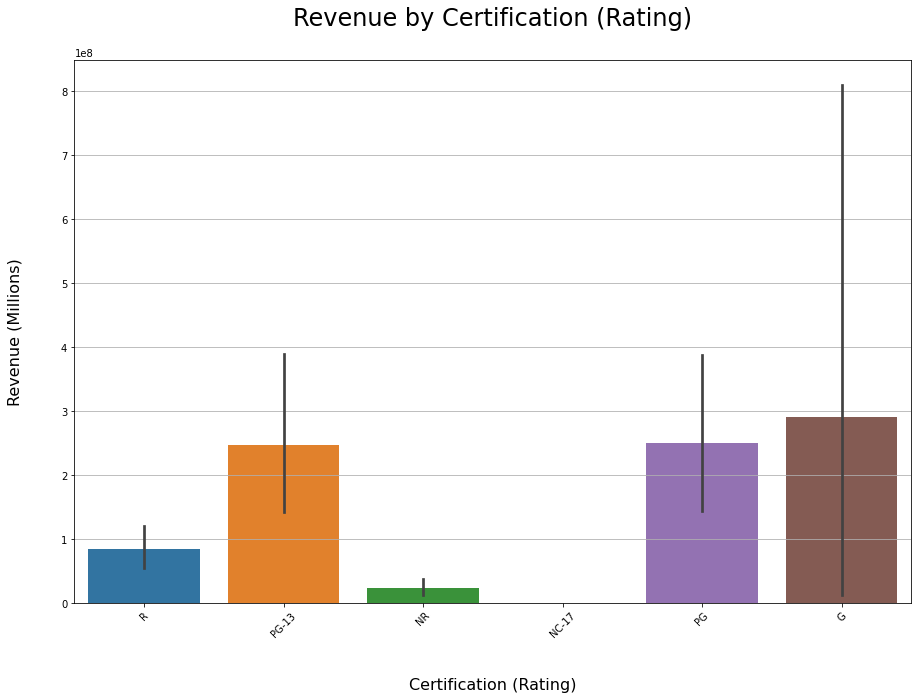

In [66]:
fig, bp = plt.subplots(nrows=1, ncols =1, figsize= (15,10))
bp = sns.barplot(data=df, x= 'certification', y = 'revenue');
plt.title('Revenue by Certification (Rating)\n', fontsize =24)
plt.ylabel('Revenue (Millions)\n\n', fontsize=16);
plt.xlabel('\n\nCertification (Rating)', fontsize=16);
plt.grid(axis='y')
plt.xticks(rotation=45);

#### ***Analysis:***

From the graph we can see that G, PG and PG-13 movies gross the highest. The are the most inclusive in when it comes to age groups; they have the largest customer pool / potential for revenue. 

### Question: Do movies released in 2020 earn less revenue than movies released in 2019?

### How do the years compare for movie ratings?

***1. State your Null Hypothesis and Alternative Hypothesis:***

$H_0$: Movies released in 2020 do not earn less than movies released in 2019.

$H_A$: Movies released in 2020 make significantly less than movies released in 2019.

***2. Select the correct test according to the data type and number of samples.***

    Type of comparison: 2 samples

    Data type: Numeric

    Hypothesis Test: 2 Sample T-Test

### Assumptions of the selected test:

    No significant outliers
    Normality
    Equal Variance

In [90]:
# Define the two groups:

rev19 = df19['revenue'].copy()

rev20 = df20['revenue'].copy()

### Test for Significant Outliers

In [91]:
# Check for outliers using Z-scores:

y19_outliers = np.abs(stats.zscore(rev19))>3
y20_outliers = np.abs(stats.zscore(rev20))>3

y19_outliers.value_counts()

False    199
True       5
Name: revenue, dtype: int64

In [69]:
y20_outliers.value_counts()

False    85
True      3
Name: revenue, dtype: int64

In [70]:
# Removal of outliers:

y19_final = rev19[-y19_outliers]
y20_final = rev20[-y20_outliers]

y19_final

1        18377736.0
2       404852543.0
3         2078370.0
4       365971656.0
5         3364426.0
           ...     
4190     15894372.0
4270      4165528.0
4276    124652206.0
4298     10000000.0
4513      1091477.0
Name: revenue, Length: 199, dtype: float64

### Normality Test

In [71]:
# Normality test for 2019:

NT2019 = stats.normaltest(y19_final)
NT2019

NormaltestResult(statistic=165.27580439894007, pvalue=1.2906695933462028e-36)

In [72]:
# Samle size for 2019 movies:

len(rev19)

204

In [73]:
# Normality test for 2019:

NT2020 = stats.normaltest(y20_final)
NT2020

NormaltestResult(statistic=68.71309496683632, pvalue=1.1998888307880135e-15)

In [74]:
# Sample size for 2020 movies:

len(rev20)

88

### ***Interpretation:***

Revenue19$_p$:1.2907x10^{-36}

Revenue20$_n$: 204

Revenue20$_p$: 1.1999x10^{-15}

Revenue20$_n$: 88

p-values for both groups are far below 0.05, meaning that our data is NOT normally distributed. This is not an issue however, because we have sample sizes of 208 and 88, both of which are well above the 15 sample minimum requirement for an independent t test. We can proceed without normalized data.

In [75]:
# Levene's test for equal variance:

revenueLT = stats.levene(y19_final, y20_final)

revenueLT.pvalue<0.05

True

In [76]:
# If-else to interpret the p-value:

if revenueLT.pvalue < 0.05:
    print('The groups ***DO NOT*** have equal variance')
    
else:
    print('The groups ***DO*** have equal variance')

The groups ***DO NOT*** have equal variance


### ***Interpretation:***

We will need to use a Welch's T test because the assumption of equal variance was inaccurate.

In [77]:
# Welch's T-Test because of unequal variance:

revenueWTT = stats.ttest_ind(y19_final, y20_final, equal_var = False)
revenueWTT

Ttest_indResult(statistic=3.9224934197391423, pvalue=0.00011041929698998684)

In [78]:
# Interpretation of final pvalue:

# Check for high significance : 

print(revenueWTT.pvalue<0.0001)

False


## ***Final Conclusion:***

p is less than alpha so we will reject the null hypothesis , that states that "Movies released in 2020 do not earn less than movies released in 2019."

In [79]:
y20_final.head()

6     47078545.0
18     2982559.0
25      709452.0
32    39238300.0
35     7060384.0
Name: revenue, dtype: float64

Text(0.5, 0, '\n2020 Movies')

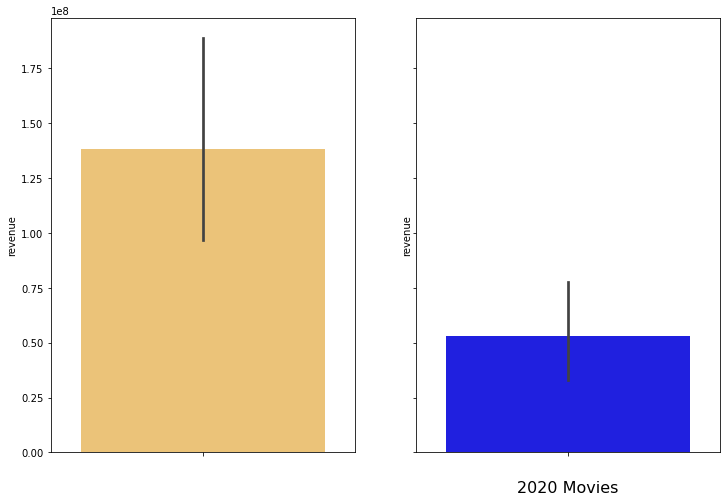

In [80]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (12,8))

a = sns.barplot(data = df19, y = 'revenue', ax= axes[0], color = 'orange', alpha =.6);
b = sns.barplot(data = df20, y = 'revenue', ax = axes[1], color = 'blue');
plt.xlabel('\n2020 Movies', fontsize = 16);
plt.xlabel('\n2020 Movies', fontsize = 16)

### ***Analysis:***

Movies released in 2020 make significantly less than movies released a year earlier in 2019. This may be due, in-part, to the COVID 19 pandemic which spawned curfews, and theater closures nationwide.

### Question: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?


***1. State your Null Hypothesis and Alternative Hypothesis:***

$H_0$: Movies that are over 2.5 hours do not make more revenue than movis that are 1.5 hours or less. 

$H_A$: Movies that are over 2.5 hours do make more revenue than movies that are 1.5 hours or less. 

***2. Select the correct test according to the data type and number of samples.***

    Type of comparison: 2 samples

    Data type: Numeric

    Hypothesis Test: 2 Sample T-Test

### Assumptions of the selected test:

    No significant outliers
    Equal variance
    Normality

In [93]:
# Define the two groups:

required_columns = ['revenue']

hours25 = df['runtime'] >= 2.5
hours15 = df['runtime'] <= 1.5

movies15 = df.loc[hours15, required_columns].copy()
movies25 = df.loc[hours25, required_columns].copy()

### Test for Significant Outliers

In [94]:
# Check for outliers using Z-scores:

m15_outliers = np.abs(stats.zscore(movies15))>3
m25_outliers = np.abs(stats.zscore(movies25))>3

m15_outliers.value_counts()

revenue
False      1
dtype: int64

In [99]:
# Removal of outliers:

m15_final = movies15[-m15_outliers]
m25_final = movies25[-m25_outliers]

### Normality Test

In [101]:
# Sample size for movies with 1.5 hour runtimes:

len(m15_final)

1

In [104]:
#Sample size for movies with 2.5 hour runtimes:

len(m25_final)

291